In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
import sys
sys.path.extend(["../"])
from core.tools.data_import import *
from core.tools.time_series import *
from core.tools.visualize import *
from core.models.feature_extracting_rnn import *
from constants import *

In [3]:
# # Select a source of file.
# pprint(UNRATE_DIR)
# #file_dir_selected = input("Select Directory ")
# file_dir_selected = "GCE"

In [4]:
# Pre-processing Parameters
PERIODS = 1
ORDER = 1
LAGS = 36

In [5]:
df = load_dataset("/home/qinchenwang/AnnEconForecast/data/UNRATE.csv")
prepared_df = differencing(df, periods=PERIODS, order=ORDER)
prepared_df.head()

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64


,UNRATE_period1_order1
DATE,
1948-01-01,NaN
1948-02-01,0.4
1948-03-01,0.2
1948-04-01,-0.1
1948-05-01,-0.4


In [6]:
X_raw, y_raw = gen_supervised_sequence(
    prepared_df, LAGS, prepared_df.columns[0], sequential_label=False)

Total 812 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (812, 36, 1), y shape = (812, 1, 1)


In [7]:
(X_train, X_test,
 y_train, y_test) = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    shuffle=False
)

(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_train, y_train,
    test_size=0.2,
    shuffle=False
)

In [8]:
# # Expand dimension so it fits the RNN input place holder.
# # (Num_Sample, time_steps, 1)
# X_train = np.expand_dims(X_train, axis=-1)
# X_test = np.expand_dims(X_test, axis=-1)
# X_val = np.expand_dims(X_val, axis=-1)

In [9]:
# y_train = np.expand_dims(y_train, axis=-1)
# y_test = np.expand_dims(y_test, axis=-1)
# y_val = np.expand_dims(y_val, axis=-1)

In [10]:
# X_raw = X_raw.reshape(812, LAGS)
# y_raw = y_raw.reshape(812, LAGS)
# print(X_raw.shape, y_raw.shape)

In [11]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_test shape: {X_test.shape}\
\ny_test shape: {y_test.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (519, 36, 1)
y_train shape: (519, 1, 1)
X_test shape: (163, 36, 1)
y_test shape: (163, 1, 1)
X_validation shape: (130, 36, 1)
y_validation shape: (130, 1, 1)


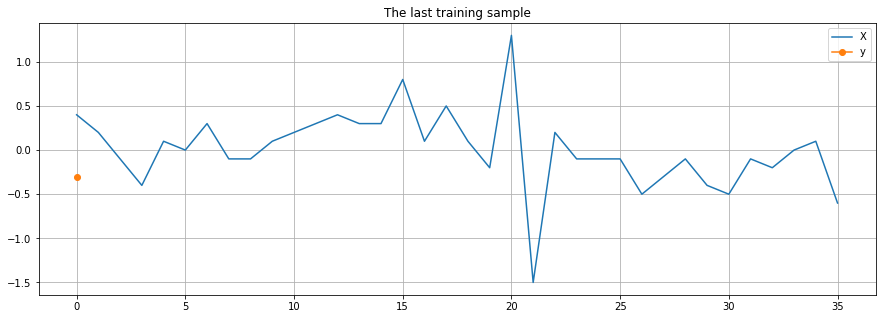

In [12]:
# One Sample
plt.figure(figsize=(15, 5))
plt.title("The last training sample")
plt.plot(X_train[0])
plt.plot(y_train[0], "-o")
plt.legend(["X", "y"])
plt.grid(True)
plt.show()

In [13]:
# Model Parameters
num_time_steps = LAGS
# Number of series used to predict. (including concurrent)
num_inputs = 1
num_outputs = 1
num_neurons = 64
# Number of output series
learning_rate = 0.03
epochs = 1500
# Training Settings
report_periods = epochs // 10

In [14]:
parameters = {
    "num_time_steps": LAGS,
    "num_inputs": 1,
    "num_outputs": 36,
    "num_neurons": 64,
    "learning_rate": 0.003
}

In [15]:
# model = ExtractingBaselineRnn(para=parameters, sequential_label=True)
# model.states.h

In [16]:
model = ExtractingBaselineRnn(para=parameters, sequential_label=True)

Model: loading parameters
Building placeholders...
Building core rnn...
Building metrics and operations...


In [19]:
hist = {"train": [], "val": []}

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "../model.ckpt")
#     sess.run(model.init)
#     for e in range(epochs):
#         progbar(e, epochs-1, 0)
#         sess.run(model.train,
#                  feed_dict={model.X: X_train, model.y: X_train})
#         if True:
#             eval_loss = lambda pred, resp: model.loss.eval(
#                 feed_dict={model.X: pred, model.y: resp})
#             train_mse = eval_loss(X_train, X_train)
#             val_mse = eval_loss(X_val, X_val)
#             # based on training set
#             persist_mse = ((X_train[1:] - X_train[:-1])**2).mean(axis=None)
#             hist["train"].append(train_mse)
#             hist["val"].append(val_mse)
#             print(f"Iteration [{e}], Training MSE {train_mse:0.7f}; Validation MSE {val_mse:0.7f}; Persistence MSE {persist_mse:0.7f}")
    
    if model.SL:
        gen_pred = lambda src: model.outputs.eval(feed_dict={model.X: src})[:,-1]
    else:
        gen_pred = lambda src: model.outputs.eval(feed_dict={model.X: src})
    p_train = gen_pred(X_train)
    p_test = gen_pred(X_test)
    save_path = saver.save(sess, "../model.ckpt")
    gen_pred1 = lambda src: model.states.c.eval(feed_dict={model.X: src})
    train_states = gen_pred1(X_train)
    test_states = gen_pred1(X_test)

INFO:tensorflow:Restoring parameters from ../model.ckpt


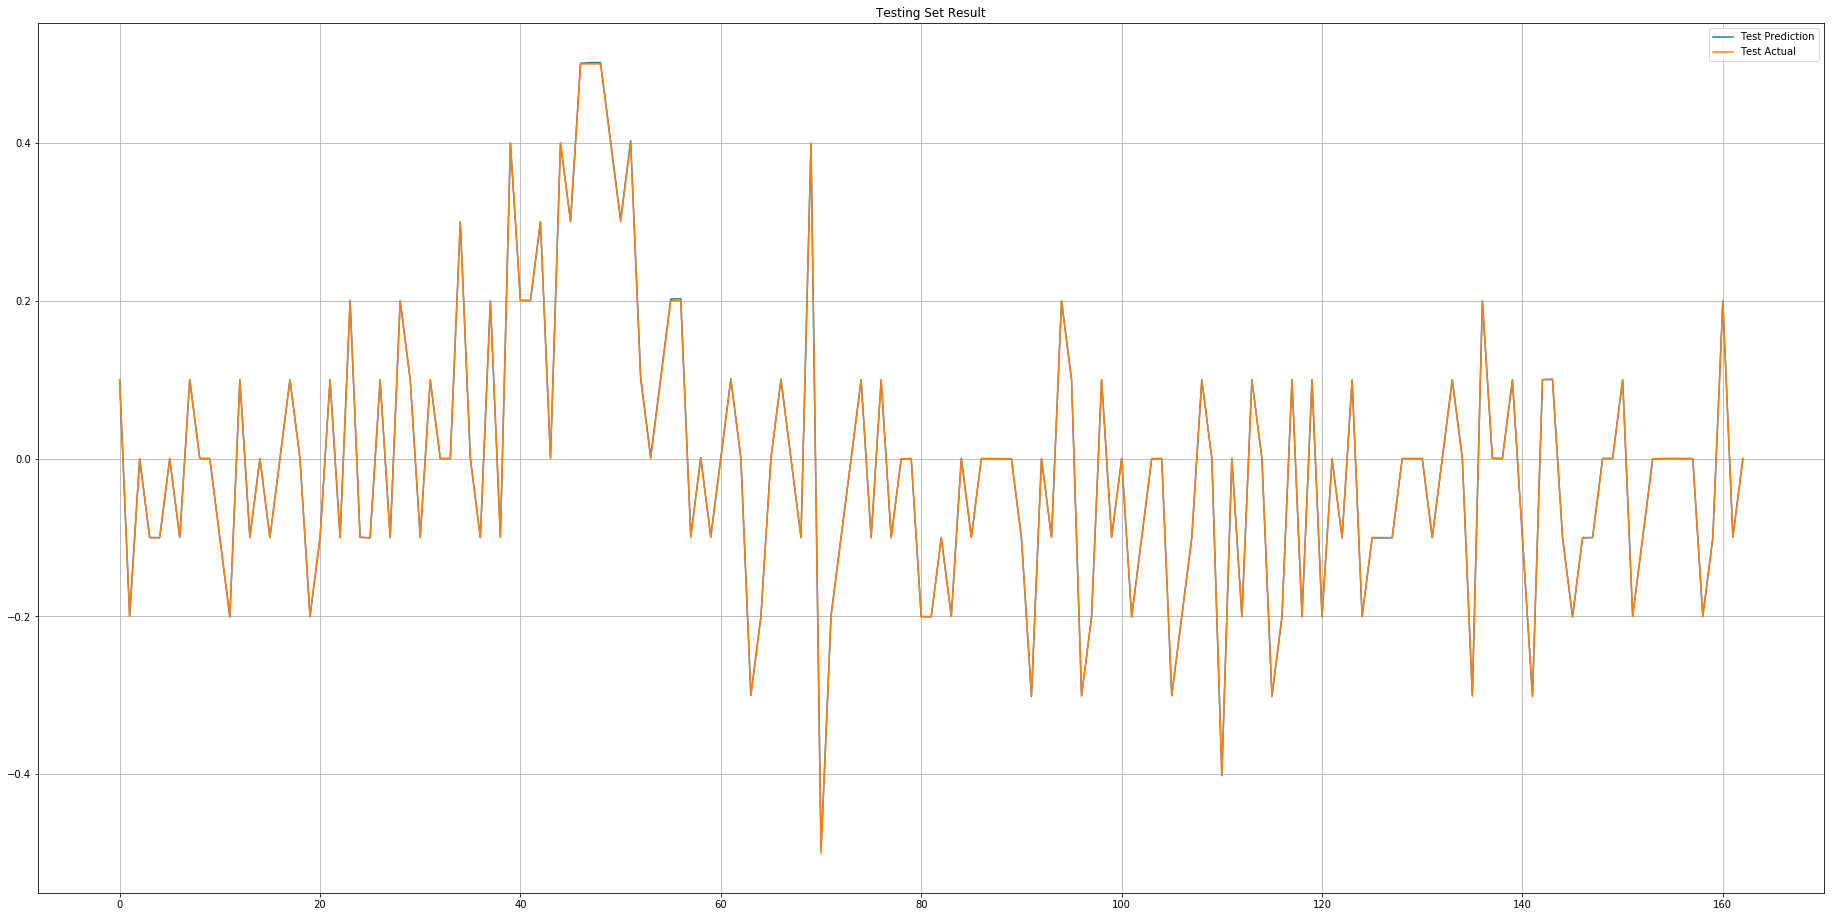

In [20]:
# Visualize testing set result
plt.close()
plt.figure(figsize=(32,16))
plt.title("Testing Set Result")
plt.plot(np.squeeze(p_test[:,-1]))
plt.plot(np.squeeze(X_test[:,-1]))
plt.legend(["Test Prediction", "Test Actual"])
plt.grid(True)
plt.show()

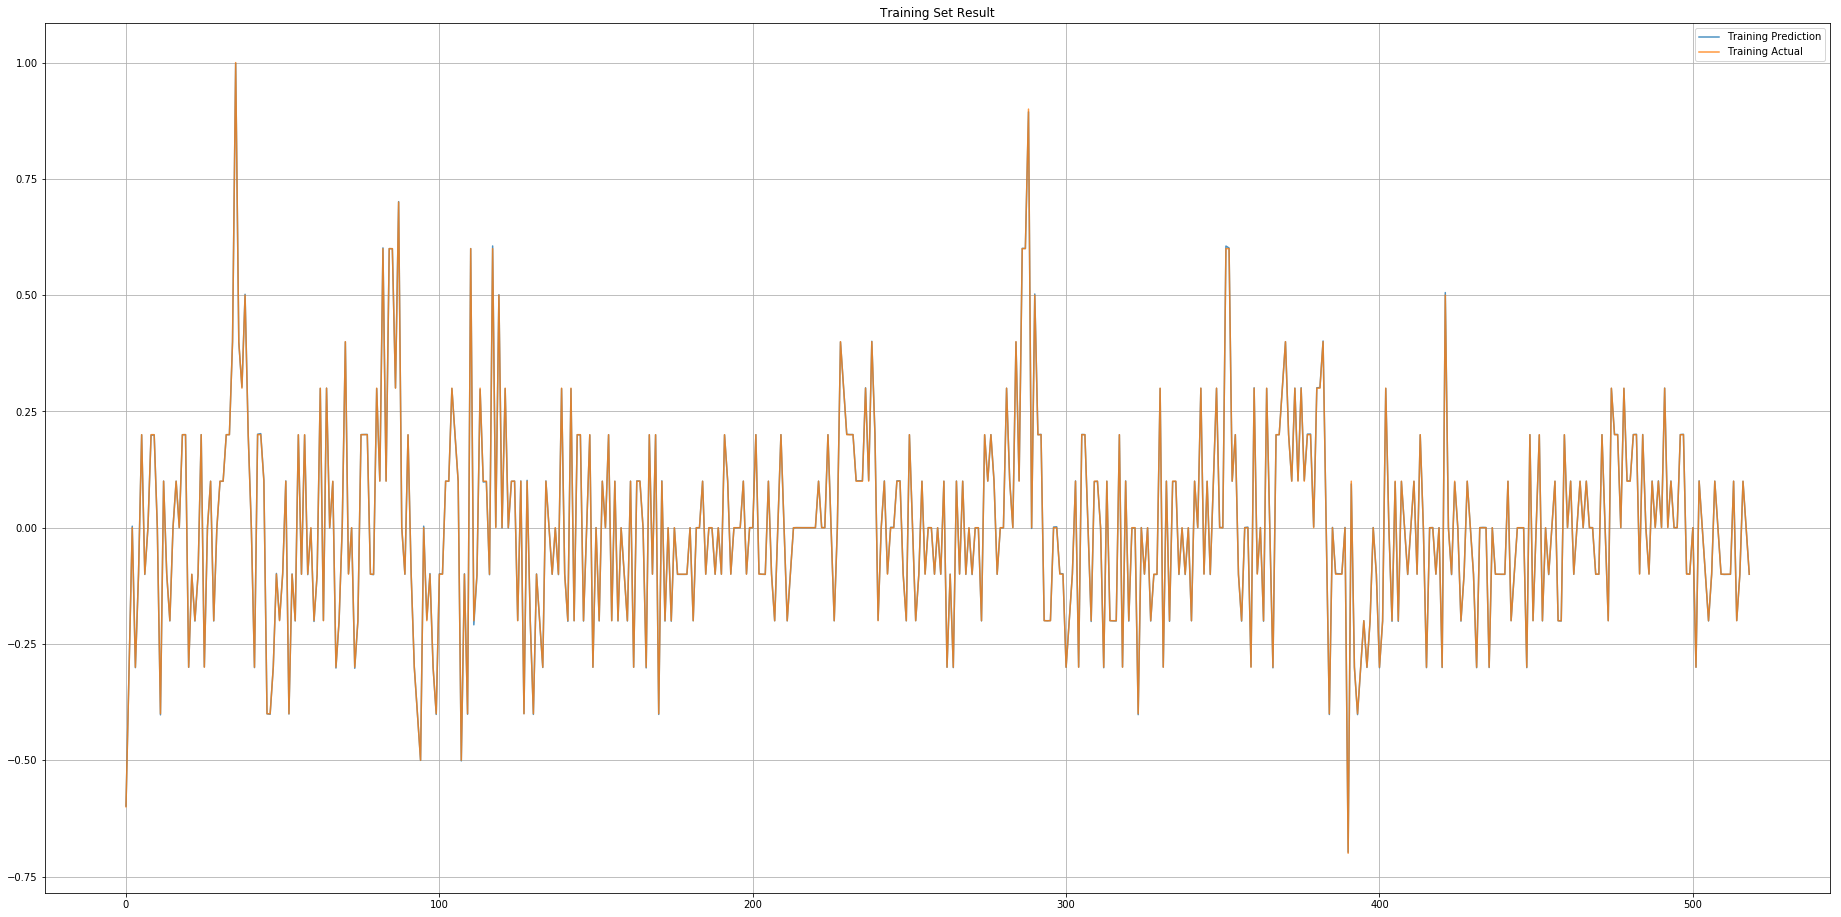

In [21]:
# Visualize training set result
plt.close()
plt.figure(figsize=(32,16))
plt.title("Training Set Result")
if model.SL:
    plt.plot(np.squeeze(p_train[:,-1]), alpha=0.8)
    plt.plot(np.squeeze(X_train[:,-1]), alpha=0.8)
else:
    plt.plot(np.squeeze(p_train), alpha=0.8)
    plt.plot(np.squeeze(X_train), alpha=0.8)
plt.legend(["Training Prediction", "Training Actual"])
plt.grid(True)
plt.show()

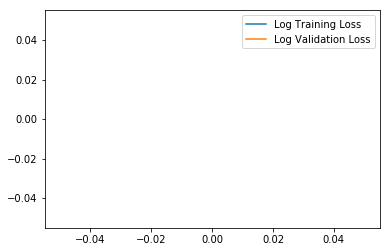

In [22]:
plt.close()
plt.plot(np.log(hist["train"]))
plt.plot(np.log(hist["val"]))
plt.legend(["Log Training Loss", "Log Validation Loss"])
plt.show()

In [28]:
parameters = {
    "num_time_steps": 64,
    "num_inputs": 1,
    "num_outputs": 1,
    "num_neurons": 128,
    "learning_rate": 0.003
}
model = ExtractingBaselineRnn(para=parameters, sequential_label=True)

train_states = train_states.reshape(-1, 64, 1)
test_states = test_states.reshape(-1, 64, 1)
y_train = y_train.reshape(-1, 1, 1)
y_test = y_test.reshape(-1, 1, 1)
print(train_states.shape, test_states.shape)

Model: loading parameters
Building placeholders...
Building core rnn...
Building metrics and operations...
(519, 64, 1) (163, 64, 1)


In [29]:
model = ExtractingBaselineRnn(para=parameters, sequential_label=True)

Model: loading parameters
Building placeholders...
Building core rnn...
Building metrics and operations...


In [36]:
hist["train"] = []
# corresponding states should be trained and recorded for the training set, don't have to make one for testing
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(model.init)
    for e in range(epochs):
        progbar(e, epochs-1, 0)
        sess.run(model.train,
                 feed_dict={model.X: train_states, model.y: y_train})
        if True:
            eval_loss = lambda pred, resp: model.loss.eval(
                feed_dict={model.X: pred, model.y: resp})
            train_mse = eval_loss(train_states, y_train)
            # based on training set
            persist_mse = ((y_train[1:] - y_train[:-1])**2).mean(axis=None)
            hist["train"].append(train_mse)
            print(f"Iteration [{e}], Training MSE {train_mse:0.7f}; Persistence MSE {persist_mse:0.7f}")
    
    gen_pred = lambda src: model.outputs.eval(feed_dict={model.X: src})[:,-1]
    p_train = gen_pred(train_states)
    p_test = gen_pred(test_states)
    save_path = saver.save(sess, "../model_pred.ckpt")

  [0/1499,   0.00%]Iteration [0], Training MSE 0.0461990; Persistence MSE 0.0705792
  [1/1499,   0.07%]Iteration [1], Training MSE 0.0438282; Persistence MSE 0.0705792
  [2/1499,   0.13%]Iteration [2], Training MSE 0.0445316; Persistence MSE 0.0705792
  [3/1499,   0.20%]Iteration [3], Training MSE 0.0446134; Persistence MSE 0.0705792
  [4/1499,   0.27%]Iteration [4], Training MSE 0.0440992; Persistence MSE 0.0705792
  [5/1499,   0.33%]Iteration [5], Training MSE 0.0437889; Persistence MSE 0.0705792
  [6/1499,   0.40%]Iteration [6], Training MSE 0.0437554; Persistence MSE 0.0705792
  [7/1499,   0.47%]Iteration [7], Training MSE 0.0438691; Persistence MSE 0.0705792
  [8/1499,   0.53%]Iteration [8], Training MSE 0.0439747; Persistence MSE 0.0705792
  [9/1499,   0.60%]Iteration [9], Training MSE 0.0439942; Persistence MSE 0.0705792
  [10/1499,   0.67%]Iteration [10], Training MSE 0.0439354; Persistence MSE 0.0705792
  [11/1499,   0.73%]Iteration [11], Training MSE 0.0438458; Persistence MS

  [96/1499,   6.40%]Iteration [96], Training MSE 0.0438287; Persistence MSE 0.0705792
  [97/1499,   6.47%]Iteration [97], Training MSE 0.0438376; Persistence MSE 0.0705792
  [98/1499,   6.54%]Iteration [98], Training MSE 0.0438409; Persistence MSE 0.0705792
  [99/1499,   6.60%]Iteration [99], Training MSE 0.0438364; Persistence MSE 0.0705792
  [100/1499,   6.67%]Iteration [100], Training MSE 0.0438296; Persistence MSE 0.0705792
  [101/1499,   6.74%]Iteration [101], Training MSE 0.0438245; Persistence MSE 0.0705792
  [102/1499,   6.80%]Iteration [102], Training MSE 0.0438220; Persistence MSE 0.0705792
  [103/1499,   6.87%]Iteration [103], Training MSE 0.0438217; Persistence MSE 0.0705792
  [104/1499,   6.94%]Iteration [104], Training MSE 0.0438224; Persistence MSE 0.0705792
  [105/1499,   7.00%]Iteration [105], Training MSE 0.0438231; Persistence MSE 0.0705792
  [106/1499,   7.07%]Iteration [106], Training MSE 0.0438233; Persistence MSE 0.0705792
  [107/1499,   7.14%]Iteration [107], Tr

  [282/1499,  18.81%]Iteration [282], Training MSE 0.0437907; Persistence MSE 0.0705792
  [283/1499,  18.88%]Iteration [283], Training MSE 0.0437887; Persistence MSE 0.0705792
  [284/1499,  18.95%]Iteration [284], Training MSE 0.0437837; Persistence MSE 0.0705792
  [285/1499,  19.01%]Iteration [285], Training MSE 0.0437775; Persistence MSE 0.0705792
  [286/1499,  19.08%]Iteration [286], Training MSE 0.0437718; Persistence MSE 0.0705792
  [287/1499,  19.15%]Iteration [287], Training MSE 0.0437674; Persistence MSE 0.0705792
  [288/1499,  19.21%]Iteration [288], Training MSE 0.0437662; Persistence MSE 0.0705792
  [289/1499,  19.28%]Iteration [289], Training MSE 0.0437660; Persistence MSE 0.0705792
  [290/1499,  19.35%]Iteration [290], Training MSE 0.0437644; Persistence MSE 0.0705792
  [291/1499,  19.41%]Iteration [291], Training MSE 0.0437609; Persistence MSE 0.0705792
  [292/1499,  19.48%]Iteration [292], Training MSE 0.0437549; Persistence MSE 0.0705792
  [293/1499,  19.55%]Iteration [

  [468/1499,  31.22%]Iteration [468], Training MSE 0.0425499; Persistence MSE 0.0705792
  [469/1499,  31.29%]Iteration [469], Training MSE 0.0422453; Persistence MSE 0.0705792
  [470/1499,  31.35%]Iteration [470], Training MSE 0.0423305; Persistence MSE 0.0705792
  [471/1499,  31.42%]Iteration [471], Training MSE 0.0424237; Persistence MSE 0.0705792
  [472/1499,  31.49%]Iteration [472], Training MSE 0.0419460; Persistence MSE 0.0705792
  [473/1499,  31.55%]Iteration [473], Training MSE 0.0420619; Persistence MSE 0.0705792
  [474/1499,  31.62%]Iteration [474], Training MSE 0.0420420; Persistence MSE 0.0705792
  [475/1499,  31.69%]Iteration [475], Training MSE 0.0416184; Persistence MSE 0.0705792
  [476/1499,  31.75%]Iteration [476], Training MSE 0.0417485; Persistence MSE 0.0705792
  [477/1499,  31.82%]Iteration [477], Training MSE 0.0412585; Persistence MSE 0.0705792
  [478/1499,  31.89%]Iteration [478], Training MSE 0.0413835; Persistence MSE 0.0705792
  [479/1499,  31.95%]Iteration [

  [654/1499,  43.63%]Iteration [654], Training MSE 0.0402690; Persistence MSE 0.0705792
  [655/1499,  43.70%]Iteration [655], Training MSE 0.0399158; Persistence MSE 0.0705792
  [656/1499,  43.76%]Iteration [656], Training MSE 0.0400316; Persistence MSE 0.0705792
  [657/1499,  43.83%]Iteration [657], Training MSE 0.0400741; Persistence MSE 0.0705792
  [658/1499,  43.90%]Iteration [658], Training MSE 0.0398285; Persistence MSE 0.0705792
  [659/1499,  43.96%]Iteration [659], Training MSE 0.0400981; Persistence MSE 0.0705792
  [660/1499,  44.03%]Iteration [660], Training MSE 0.0398170; Persistence MSE 0.0705792
  [661/1499,  44.10%]Iteration [661], Training MSE 0.0399577; Persistence MSE 0.0705792
  [662/1499,  44.16%]Iteration [662], Training MSE 0.0398931; Persistence MSE 0.0705792
  [663/1499,  44.23%]Iteration [663], Training MSE 0.0398016; Persistence MSE 0.0705792
  [664/1499,  44.30%]Iteration [664], Training MSE 0.0398852; Persistence MSE 0.0705792
  [665/1499,  44.36%]Iteration [

  [840/1499,  56.04%]Iteration [840], Training MSE 0.0395133; Persistence MSE 0.0705792
  [841/1499,  56.10%]Iteration [841], Training MSE 0.0391511; Persistence MSE 0.0705792
  [842/1499,  56.17%]Iteration [842], Training MSE 0.0393561; Persistence MSE 0.0705792
  [843/1499,  56.24%]Iteration [843], Training MSE 0.0390755; Persistence MSE 0.0705792
  [844/1499,  56.30%]Iteration [844], Training MSE 0.0393952; Persistence MSE 0.0705792
  [845/1499,  56.37%]Iteration [845], Training MSE 0.0391429; Persistence MSE 0.0705792
  [846/1499,  56.44%]Iteration [846], Training MSE 0.0392229; Persistence MSE 0.0705792
  [847/1499,  56.50%]Iteration [847], Training MSE 0.0391899; Persistence MSE 0.0705792
  [848/1499,  56.57%]Iteration [848], Training MSE 0.0390118; Persistence MSE 0.0705792
  [849/1499,  56.64%]Iteration [849], Training MSE 0.0391565; Persistence MSE 0.0705792
  [850/1499,  56.70%]Iteration [850], Training MSE 0.0389809; Persistence MSE 0.0705792
  [851/1499,  56.77%]Iteration [

  [1026/1499,  68.45%]Iteration [1026], Training MSE 0.0384364; Persistence MSE 0.0705792
  [1027/1499,  68.51%]Iteration [1027], Training MSE 0.0384829; Persistence MSE 0.0705792
  [1028/1499,  68.58%]Iteration [1028], Training MSE 0.0384523; Persistence MSE 0.0705792
  [1029/1499,  68.65%]Iteration [1029], Training MSE 0.0384216; Persistence MSE 0.0705792
  [1030/1499,  68.71%]Iteration [1030], Training MSE 0.0383656; Persistence MSE 0.0705792
  [1031/1499,  68.78%]Iteration [1031], Training MSE 0.0383284; Persistence MSE 0.0705792
  [1032/1499,  68.85%]Iteration [1032], Training MSE 0.0383704; Persistence MSE 0.0705792
  [1033/1499,  68.91%]Iteration [1033], Training MSE 0.0384687; Persistence MSE 0.0705792
  [1034/1499,  68.98%]Iteration [1034], Training MSE 0.0385591; Persistence MSE 0.0705792
  [1035/1499,  69.05%]Iteration [1035], Training MSE 0.0385001; Persistence MSE 0.0705792
  [1036/1499,  69.11%]Iteration [1036], Training MSE 0.0383698; Persistence MSE 0.0705792
  [1037/14

  [1208/1499,  80.59%]Iteration [1208], Training MSE 0.0385831; Persistence MSE 0.0705792
  [1209/1499,  80.65%]Iteration [1209], Training MSE 0.0381737; Persistence MSE 0.0705792
  [1210/1499,  80.72%]Iteration [1210], Training MSE 0.0378957; Persistence MSE 0.0705792
  [1211/1499,  80.79%]Iteration [1211], Training MSE 0.0385345; Persistence MSE 0.0705792
  [1212/1499,  80.85%]Iteration [1212], Training MSE 0.0381556; Persistence MSE 0.0705792
  [1213/1499,  80.92%]Iteration [1213], Training MSE 0.0381142; Persistence MSE 0.0705792
  [1214/1499,  80.99%]Iteration [1214], Training MSE 0.0383634; Persistence MSE 0.0705792
  [1215/1499,  81.05%]Iteration [1215], Training MSE 0.0378149; Persistence MSE 0.0705792
  [1216/1499,  81.12%]Iteration [1216], Training MSE 0.0382171; Persistence MSE 0.0705792
  [1217/1499,  81.19%]Iteration [1217], Training MSE 0.0381218; Persistence MSE 0.0705792
  [1218/1499,  81.25%]Iteration [1218], Training MSE 0.0377958; Persistence MSE 0.0705792
  [1219/14

  [1390/1499,  92.73%]Iteration [1390], Training MSE 0.0386378; Persistence MSE 0.0705792
  [1391/1499,  92.80%]Iteration [1391], Training MSE 0.0388689; Persistence MSE 0.0705792
  [1392/1499,  92.86%]Iteration [1392], Training MSE 0.0381577; Persistence MSE 0.0705792
  [1393/1499,  92.93%]Iteration [1393], Training MSE 0.0379385; Persistence MSE 0.0705792
  [1394/1499,  93.00%]Iteration [1394], Training MSE 0.0383860; Persistence MSE 0.0705792
  [1395/1499,  93.06%]Iteration [1395], Training MSE 0.0381250; Persistence MSE 0.0705792
  [1396/1499,  93.13%]Iteration [1396], Training MSE 0.0383538; Persistence MSE 0.0705792
  [1397/1499,  93.20%]Iteration [1397], Training MSE 0.0384669; Persistence MSE 0.0705792
  [1398/1499,  93.26%]Iteration [1398], Training MSE 0.0385370; Persistence MSE 0.0705792
  [1399/1499,  93.33%]Iteration [1399], Training MSE 0.0383775; Persistence MSE 0.0705792
  [1400/1499,  93.40%]Iteration [1400], Training MSE 0.0383563; Persistence MSE 0.0705792
  [1401/14

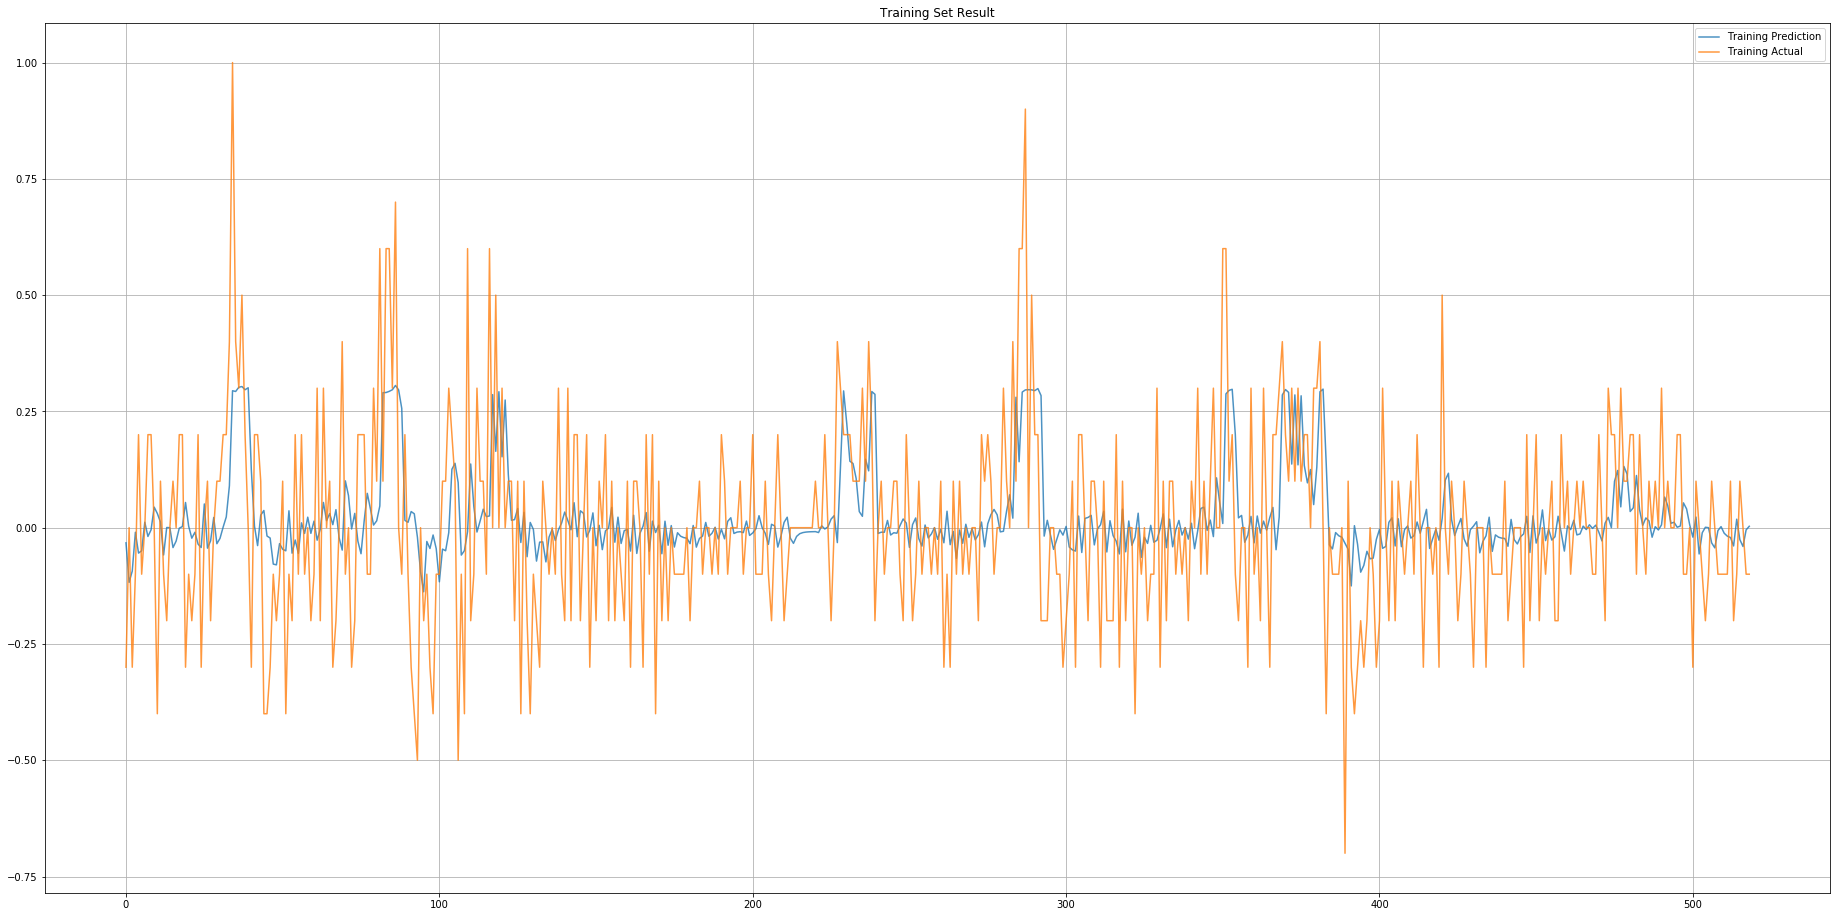

In [37]:
# Visualize training set result
plt.close()
plt.figure(figsize=(32,16))
plt.title("Training Set Result")
plt.plot(np.squeeze(p_train[:,-1]), alpha=0.8)
plt.plot(np.squeeze(y_train[:,-1]), alpha=0.8)
plt.legend(["Training Prediction", "Training Actual"])
plt.grid(True)
plt.show()

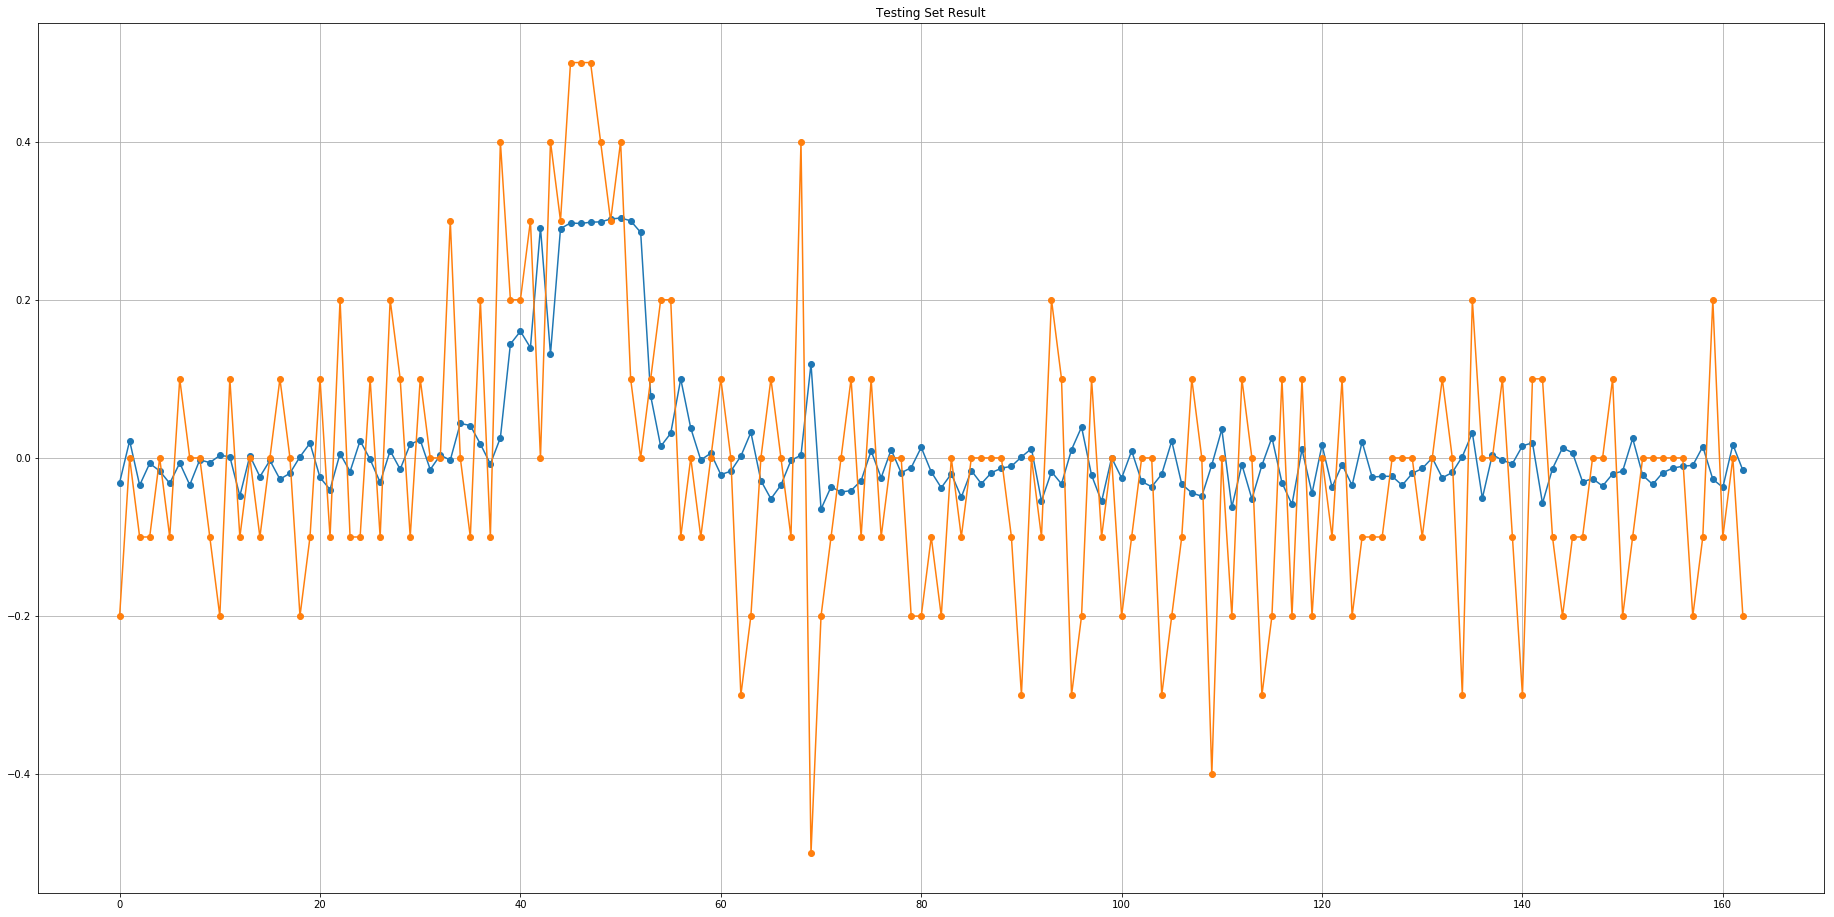

In [47]:
# Visualize testing set result
plt.close()
plt.figure(figsize=(32,16))
plt.title("Testing Set Result")
#plt.plot(np.squeeze(p_test))
#plt.plot(np.squeeze(y_test[:,-1]))
plt.errorbar(list(range(len(p_test))), p_test, marker='o')
plt.errorbar(list(range(len(y_test[:, -1]))), y_test[:,-1], marker='o')
#plt.legend(["Test Prediction", "Test Actual"])
plt.grid(True)
plt.show()

In [1]:
# start with initial credibility
cred = 1000
for i in range(len(y_raw)):
    if y_raw[i][0] * pred[i][0] >= 0:
        # predicted the same sign
        cred += 1
    else:
        cred -= 1
print(cred)

NameError: name 'y_raw' is not defined